In [1]:
#bagian Import-Importan
import json
import datetime
import mysql.connector
import pandas as pd
import numpy as np
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import requests
from pymysql import*
import xlwt
import pandas.io.sql as sql
import matplotlib.pyplot as plt
import geopandas as gpd

In [9]:
#Melakukan Koneksi to Database
mydb = mysql.connector.Connect(
    host="127.0.0.1",
    user="root",
    password="",
    database="db_scopus"
)
headers = {'user-agent':'Chrome'}
cursor = mydb.cursor()
mydb.commit()

In [10]:
#Melakukan Setting Chromedriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
chrome_options.add_experimental_option('useAutomationExtension', False)
chrome_options.add_argument("--disable-web-security")
chrome_options.add_argument("--allow-running-insecure-content")
chrome_options.add_argument("--enable-javascript")
chrome_options.add_argument('--disable-infobars')
chrome_options.add_argument('--profile-directory=Default')
chrome_options.add_argument("--disable-plugins-discovery")
chrome_options.add_argument("--start-maximized")


In [ ]:
# Mendapatkan Data: Afid, nama pt, jumlahdokumen institusi, jumlahdokumen afiliasi, asal kota)
driver = webdriver.Chrome(chrome_options=chrome_options,executable_path=r'C:\Users\adam.nurzaman\Documents\chromedriver\chromedriver.exe')
#driver = webdriver.Chrome(executable_path=os.popen('which chromedriver').read().strip())
statis="https://www.scopus.com/results/affiliationResults.uri?resultsPerPage=20&offset=1&sort=afcnt-f&jtp=false&allField=off&allField2=off&tooManySelections=false&previousSelectionCount=0&preferredName=&affiliationId=&sid=02c77f8226d5ae4fd42e012796b4109f&searchDataID=81ab1d09be22a0a349031736d5a963e9&selectionPageSearch=afsp&affilName=Indonesia&s=AFFIL%28Indonesia%29&cl=t&showFullList=false&setTargetUrl=t&src=af&st1=&st2=&sot=afsp&sdt=cl&cluster=instaffilctry%2c%22Indonesia%22%2ct&sl=16&origin=AffiliationNamesList&zone=leftSideBar&txGid=9d9c754beb021f368d9b3956058c7d81"
n=1
driver.get(statis)
driver.execute_script("window.open('"+statis+"','new_window')")
driver.get(statis)
htmls = driver.page_source
pous = BeautifulSoup(htmls)
span = pous.find("span", class_='resultsCount')
jml=span.string
while n <= int(jml) :
    linka="https://www.scopus.com/results/affiliationResults.uri?resultsPerPage=20&offset="+str(n)+"&sort=afcnt-f&jtp=false&allField=off&allField2=off&tooManySelections=false&previousSelectionCount=0&preferredName=&affiliationId=&sid=02c77f8226d5ae4fd42e012796b4109f&searchDataID=81ab1d09be22a0a349031736d5a963e9&selectionPageSearch=afsp&affilName=Indonesia&s=AFFIL%28Indonesia%29&cl=t&showFullList=false&setTargetUrl=t&src=af&st1=&st2=&sot=afsp&sdt=cl&cluster=instaffilctry%2c%22Indonesia%22%2ct&sl=16&origin=AffiliationNamesList&zone=leftSideBar&txGid=9d9c754beb021f368d9b3956058c7d81"
    #print(linka)
    driver.get(linka)
    driver.execute_script("window.open('"+linka+"','new_window')")
    driver.get(linka)
    html = driver.page_source
    soup = BeautifulSoup(html)
    affiliationID=""
    #print(soup) 
    table = soup.find("table", id="srchResultsList")
    for tr in table.find_all('tr',class_='searchArea') :
        #print(tr)
        i = 0
        for td in tr.find_all('td') :
            if i == 0 :
                link = td.find('a', href=True)['href']
                affiliationID = link.split("?id=")[1].split("&offset")[0] 
                for a in td.find_all('a', limit=1) :
                    univ=a.string      
            if i == 1 :
                for a in td.find_all('a', limit=1) :
                    AffiliationCount = a.string
                    #print("Jumlah Affiliasi :"+AffiliationCount)
            if i == 2 :
                for a in td.find_all('a',limit=1) :
                    institutionCount = a.string
                    #print("Jumlah Institusi Kolaborasi :"+institutionCount)
            if i == 3 :
                asalKota=str(td.string)
                #print("asalKotak : "+asalKota)
            i+=1
        #print(affiliationID+"=="+univ+"=="+AffiliationCount+"=="+institutionCount+"=="+asalKota)
        try:
            cursor = mydb.cursor()
            query="SELECT * FROM db_scopus.t_pt_scopus WHERE affiliation_id="+str(affiliationID)+""
            cursor.execute(query)
            records = cursor.fetchall()
            if len(records)==0:
                cursor = mydb.cursor()
                data = cursor.execute("INSERT INTO db_scopus.t_pt_scopus(affiliation_id,nama_pt,jml_dokumen_institusi,jml_dokumen_afiliasi_only,asal_kota_pt,flag) VALUES(%s,%s,%s,%s,%s,%s)",(str(affiliationID),str(univ),str(institutionCount),str(AffiliationCount),str(asalKota),str(0)))
                mydb.commit()
                print("Affiliation ID :"+affiliationID+" == "+"Nama Univ :"+univ+" Inserted")
            else :
                cursor = mydb.cursor()
                cursor.execute("UPDATE db_scopus.t_pt_scopus SET jml_dokumen_institusi=%s, jml_dokumen_afiliasi_only=%s WHERE affiliation_id=%s",(str(institutionCount),str(AffiliationCount),str(affiliationID)))
                mydb.commit()
                print("Affiliation ID :"+affiliationID+" == "+"Nama Univ :"+univ+" Updated")
        except KeyError:
            continue
    n+=20

In [ ]:
#Melakukan Update Jumlah Author
cursor = mydb.cursor()
query="SELECT affiliation_id from db_scopus.t_pt_scopus WHERE flag=0"
cursor.execute(query)
records = cursor.fetchall()
mydb.commit()
for row in records:
    afid = str(row)[2:10]
    #print(afid)
    #API KEY
    #url_author='https://api.elsevier.com/content/search/author?query=AF-ID'+repr(row)+'&apiKey=7f59af901d2d86f78a1fd60c1bf9426a'
    url_author='https://api.elsevier.com/content/search/author?query=AF-ID('+str(afid)+')&apiKey=8f3f253d46bb557e6281ca16149707bf'
    #print(url_author)
    data_tot = requests.get(url_author).json()   
    #print(data_tot)
    if 'opensearch:totalResults' in data_tot['search-results']:
        jml_author = data_tot['search-results']['opensearch:totalResults']
        cursor = mydb.cursor()
        cursor.execute("update db_scopus.t_pt_scopus set jml_author=%s, flag=%s where affiliation_id=%s",(str(jml_author),str(1),str(afid)))
        mydb.commit()
        print(str(jml_author)+"=="+str(afid))
        time.sleep(1)
    else:
        print("Ga ada")
        continue
        time.sleep(1)

In [ ]:
#Mendapatkan data Document Source
driver = webdriver.Chrome(chrome_options=chrome_options,executable_path=r'C:\Users\adam.nurzaman\Documents\chromedriver\chromedriver.exe')
statis="https://www.scopus.com/affil/counts.uri?id=60103610"
driver.get(statis)
cursor = mydb.cursor()
qq="DELETE FROM db_scopus.t_document_source WHERE jml_dokumen is not null"
cursor.execute(qq)
time.sleep(1)
cursor = mydb.cursor()
query="SELECT affiliation_id from t_pt_scopus"
cursor.execute(query)
records = cursor.fetchall()
mydb.commit()
for afid in records :
    affilitaion = str(afid[0])
    #url ="https://www.scopus.com/affil/counts.uri?id="+affilitaion""
    driver.get("https://www.scopus.com/affil/counts.uri?id="+affilitaion)
    time.sleep(1)
    try:
        html = driver.page_source
        soup = BeautifulSoup(html)
        #print(soup.prettify)
        for table in soup.find_all("table", class_="tableWithNoLeftPadding table marginTop1") :
            for tr in table.find_all('tr', class_="tableRowWithTopBorder docsBySourceListItem") :
                #print(tr)
                i=0
                for td in tr.find_all('td') :
                    if i == 0 :
                        source = td.string
                        #print(td.string)
                    if i == 1 : 
                        for a in td.find_all('a') :
                            for span in a.find_all('span',class_='anchorText') :
                                jml = span.string
                                #print(span.string)
                    i+=1
                print(source+" "+jml+" "+affilitaion)
                cursor = mydb.cursor()
                data = cursor.execute("INSERT INTO db_scopus.t_document_source(affiliation_id,nama_source,jml_dokumen) VALUES(%s,%s,%s)",(str(affilitaion),str(source),str(jml)))
                mydb.commit()
    except KeyError:
        continue


In [ ]:
#Export Database to csv t_pt_scopus
con=connect(user="root",password="",host="127.0.0.1",database="db_scopus")
df = sql.read_sql("SELECT * FROM db_scopus.t_pt_scopus",con)
print(df)
df.to_csv('t_pt_scopus.csv')

In [ ]:
#Export Database to CSV t_document_source
con=connect(user="root",password="",host="127.0.0.1",database="db_scopus")
df = sql.read_sql("SELECT * FROM db_scopus.t_document_source",con)
print(df)
df.to_csv('t_document_source.csv')

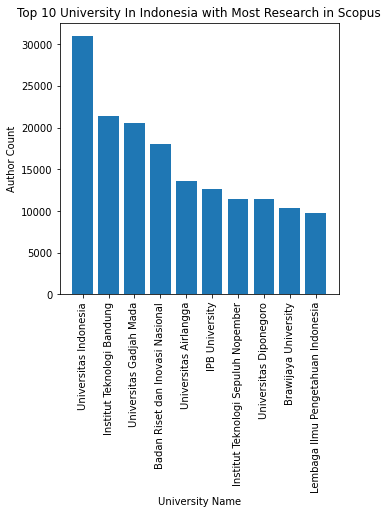

In [17]:
#Plotbar from Affiliation_id & jumlah dokumen institusi
table = pd.read_csv("D:/OneDrive - Bina Nusantara/!DAPB/!github/BIRA/t_pt_scopus.csv")
top_data = table.nlargest(10, 'jml_dokumen_institusi')
x_label = top_data['affiliation_id']
plt.bar(x=np.arange(len(x_label)),height=top_data['jml_dokumen_institusi'])
plt.xticks(np.arange(len(x_label)), top_data['nama_pt'], rotation=90)
plt.title('Top 10 University In Indonesia with Most Research in Scopus')
plt.xlabel('University Name')
plt.ylabel('Author Count')
plt.rcParams['figure.figsize'] = [5,10]
plt.show()

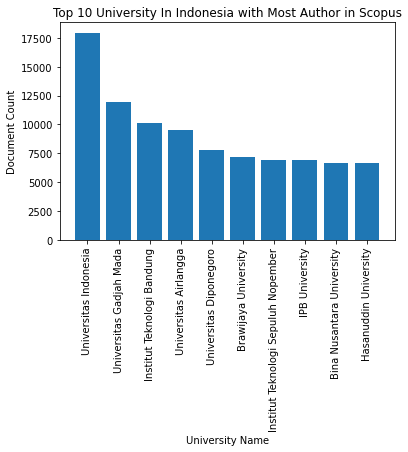

In [41]:
#Top 10 Author terbanyak Universitas Indonesia Terindex Scopus
table = pd.read_csv("D:/OneDrive - Bina Nusantara/!DAPB/!github/BIRA/t_pt_scopus.csv")

# Get top 10 data based on jumlah author
top_data = table.nlargest(10, 'jml_author')

# Create the bar chart
x_label = top_data['affiliation_id']
plt.bar(x=np.arange(len(x_label)), height=top_data['jml_author'])
plt.xticks(np.arange(len(x_label)), top_data['nama_pt'], rotation=90)

# Set title and labels for the chart
plt.title('Top 10 University In Indonesia with Most Author in Scopus')
plt.xlabel('University Name')
plt.ylabel('Document Count')

# Display the chart
plt.show()

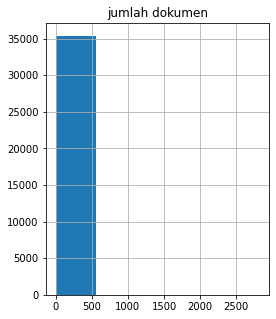

In [2]:
#pertemuan 12
table_pt = pd.read_csv("D:/OneDrive - Bina Nusantara/!DAPB/!github/BIRA/t_pt_scopus.csv")
table_ds = pd.read_csv("D:/OneDrive - Bina Nusantara/!DAPB/!github/BIRA/t_document_source.csv")
#Convert jml_dokumen become float
table_ds['jml_dokumen'] = table_ds['jml_dokumen'].str.replace(',', '')
table_ds['jml_dokumen'] = table_ds['jml_dokumen'].astype(float)
table_pt['nama_pt'] = table_pt['nama_pt'].str.replace('\n', '')
table_pt['nama_pt'] = table_pt['nama_pt'].str.replace('\t', '')

#Membaca 5 Data Teratas
#print(table.head())

#Membaca 5 Data Terbawah
#print(table.tail())

#menampilkan informasi Statistik dengan Numpy
#print(table_ds.describe(exclude=['O']))
#print(table_ds.describe())

#median
#print("Median = ",table_ds.loc[:, "jml_dokumen"].median())

#mean Rata-rata
rata_ja_nmpt = table_pt['jml_author'].groupby(table_pt['nama_pt']).mean()
rata_ai_nmsrc= table_ds['jml_dokumen'].groupby(table_ds['nama_source']).mean()
#print("Rata - Rata dari Jumlah Author per PT = ",rata_ja_nmpt)
#print("Rata - Rata dari Jumlah Dokumen per Nama Source = ",rata_ai_nmsrc)

#rename header data
table_ds.rename(columns={"jml_dokumen":"jumlah dokumen"},inplace=True)

#sorting jml dokumen terbanyak
sort_dkmn = table_ds.sort_values(by='jumlah dokumen',ascending=0)
#print(sort_dkmn)

table_ds[['jumlah dokumen']].hist(figsize=(4,5),bins=5)
plt.show()




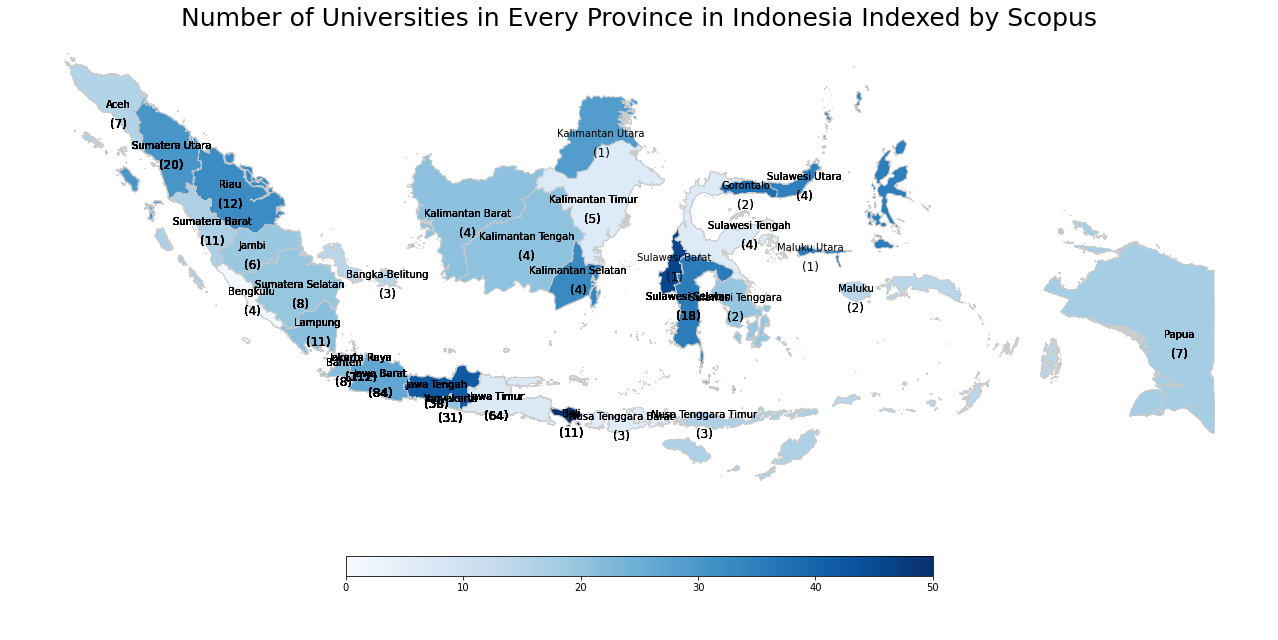

In [18]:
#Sebaran Universitas di Indonesia Terindeks Scopus berdasarkan Provinsi
fp = "D:/OneDrive - Bina Nusantara/!DAPB/!github/BIRA/map/IDN_adm1.shp"
province = pd.read_csv("D:/OneDrive - Bina Nusantara/!DAPB/!github/BIRA/t_pt_scopus.csv")
province['nama_pt'] = province['nama_pt'].str.replace('\n', '')
province['nama_pt'] = province['nama_pt'].str.replace('\t', '')
map_df = gpd.read_file(fp)
# check the GeoDataframe
plt.rcParams['figure.figsize'] = [50, 70] #height, width
#map_df.plot()
#province.head()
counts = province.groupby('provinsi_pt').agg({'nama_pt': 'count'})
counts = counts.reset_index().rename(columns={'nama_pt': 'count'})
#print(counts)

#join the geodataframe with the csv dataframe
merged = map_df.merge(province, how='left', left_on="NAME_1", right_on="provinsi_pt")
merged = merged[['affiliation_id','nama_pt','jml_author','jml_dokumen_institusi', 'provinsi_pt','geometry']]
merged = merged.merge(counts, on='provinsi_pt')
#merged.head()

# set the value column that will be visualised
variable = 'nama_pt'
# set the range for the choropleth values
vmin, vmax = 0, 50
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))
# remove the axis
ax.axis('off')
# add a title and annotation
ax.set_title('Number of Universities in Every Province in Indonesia Indexed by Scopus', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')
# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.1, aspect = 30)
# create map
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

# Add Labels
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
for idx, row in merged.iterrows():
    #plt.annotate(text=row['provinsi_pt'], xy=row['coords'],horizontalalignment='center')
    plt.annotate(text=row['provinsi_pt'], xy=row['coords'],horizontalalignment='center')
    # add label for count value
    plt.annotate(text=f"({row['count']})", xy=row['coords'], xytext=(0, -20), textcoords='offset points', ha='center', fontsize=12)
#fig.savefig(‘map.png’, dpi=300)